# hands-on activity: data analysis of fMRI data from Le Petit Prince project

Christophe Pallier <christophe@pallier.org>  
Aug. 2025


 Le Petit Prince fMRI dataset is described in [Li, Jixing, Shohini Bhattasali, Shulin Zhang, et al. 2022. “Le Petit Prince Multilingual Naturalistic fMRI Corpus.” Scientific Data](http://www.nature.com/articles/s41597-022-01625-7)

 Data are available <https://openneuro.org/datasets/ds003643/versions/2.0.7>.


 As the amount of data is very large (>600GB), in this notebook, we will to "play" with data averaged across participants.








The repository
https://github.com/chrplr/lpp_average_subject_en
provides data obtained by averaging
the preprocessed bold files from the 49 English speaking participants.

In [1]:
!git clone https://github.com/chrplr/lpp_average_subject_en
!ls -R

fatal: destination path 'lpp_average_subject_en' already exists and is not an empty directory.
.:
lpp_average_subject_en	sample_data

./lpp_average_subject_en:
annotation  create_avg_subject.py  mni152.nii.gz  roi_masks
bold	    mask_lpp_en.nii.gz	   README.md	  TD_lpp.ipynb

./lpp_average_subject_en/annotation:
lppEN_coreference.csv	 lppEN_section6.TextGrid
lppEN_dependency.csv	 lppEN_section7.TextGrid
lppEN_prosody.csv	 lppEN_section8.TextGrid
lppEN_section1.TextGrid  lppEN_section9.TextGrid
lppEN_section2.TextGrid  lppEN_tree.csv
lppEN_section3.TextGrid  lppEN_word_embeddings_GloVe.csv
lppEN_section4.TextGrid  lppEN_word_information.csv
lppEN_section5.TextGrid

./lpp_average_subject_en/bold:
lpp_en_avg49ss_run1_bold.nii.gz  lpp_en_avg49ss_run6_bold.nii.gz
lpp_en_avg49ss_run2_bold.nii.gz  lpp_en_avg49ss_run7_bold.nii.gz
lpp_en_avg49ss_run3_bold.nii.gz  lpp_en_avg49ss_run8_bold.nii.gz
lpp_en_avg49ss_run4_bold.nii.gz  lpp_en_avg49ss_run9_bold.nii.gz
lpp_en_avg49ss_run5_bold.nii.gz

./l

We will use the [nilearn](https://nilearn.github.io) library to manipulate and analyse fMRI files.

In [2]:
!uv pip install nilearn ipyniivue pandas   # if you do not have `uv`, delete it and just use `pip`

Using Python 3.12.11 environment at: /usr
Audited 3 packages in 479ms


In [3]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:


root_dir = Path("lpp_average_subject_en/")

bold_dir = root_dir / "bold"
bold_files = sorted(list(bold_dir.glob("*.gz")))
bold_files


[PosixPath('lpp_average_subject_en/bold/lpp_en_avg49ss_run1_bold.nii.gz'),
 PosixPath('lpp_average_subject_en/bold/lpp_en_avg49ss_run2_bold.nii.gz'),
 PosixPath('lpp_average_subject_en/bold/lpp_en_avg49ss_run3_bold.nii.gz'),
 PosixPath('lpp_average_subject_en/bold/lpp_en_avg49ss_run4_bold.nii.gz'),
 PosixPath('lpp_average_subject_en/bold/lpp_en_avg49ss_run5_bold.nii.gz'),
 PosixPath('lpp_average_subject_en/bold/lpp_en_avg49ss_run6_bold.nii.gz'),
 PosixPath('lpp_average_subject_en/bold/lpp_en_avg49ss_run7_bold.nii.gz'),
 PosixPath('lpp_average_subject_en/bold/lpp_en_avg49ss_run8_bold.nii.gz'),
 PosixPath('lpp_average_subject_en/bold/lpp_en_avg49ss_run9_bold.nii.gz')]

/tmp/ipython-input-2000808194.py:4: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  plot_epi(mean_img(bold_files[0]))


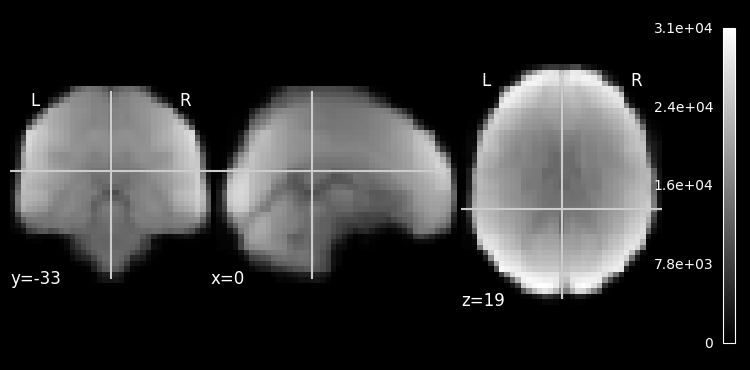

In [5]:
from nilearn.image import mean_img
from nilearn.plotting import plot_epi

plot_epi(mean_img(bold_files[0]))

In [6]:
# interactive version, fusioned with anatomy template

import ipyniivue
from ipyniivue import NiiVue, SliceType

volumes = [
    {
        "path": root_dir / "mni152.nii.gz",
        "colormap": "gray",
        "visible": True,
        "opacity": 1.0,
    },
    {
        "path": bold_files[0],
        "colormap": "red",
        "visible": True,
        "opacity": 1,
    },
]



nv = NiiVue(slice_type=SliceType.MULTIPLANAR)
nv.load_volumes(volumes)
nv.volumes[0].opacity = 0.5
nv.volumes[1].opacity = 0.5
nv



NiiVue(clip_plane_depth_azi_elev=[2.0, 0.0, 0.0], draw_lut=None, graph=<ipyniivue.traits.Graph object at 0x7a4…

# Get the Regions of Interest (ROIs) and display them

[PosixPath('lpp_average_subject_en/roi_masks/AG_TPJ.nii.gz'), PosixPath('lpp_average_subject_en/roi_masks/BA44.nii.gz'), PosixPath('lpp_average_subject_en/roi_masks/BA45.nii.gz'), PosixPath('lpp_average_subject_en/roi_masks/BA47.nii.gz'), PosixPath('lpp_average_subject_en/roi_masks/TP.nii.gz'), PosixPath('lpp_average_subject_en/roi_masks/aSTS.nii.gz'), PosixPath('lpp_average_subject_en/roi_masks/pSTS.nii.gz')]


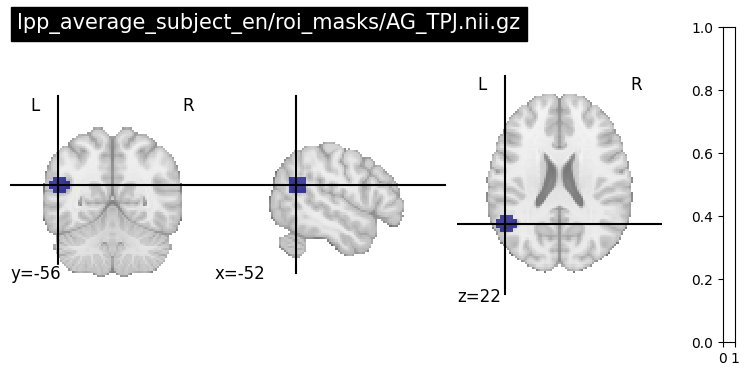

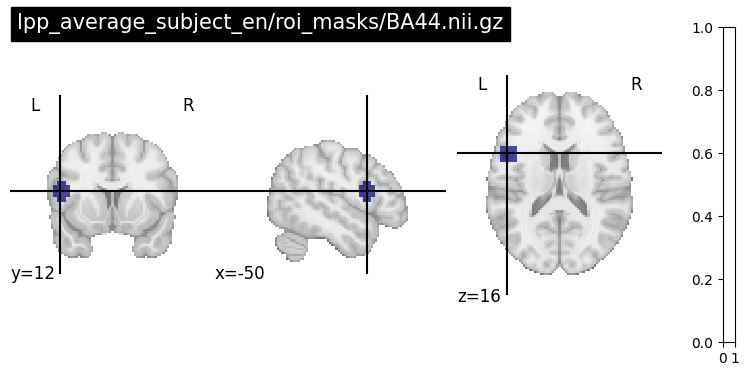

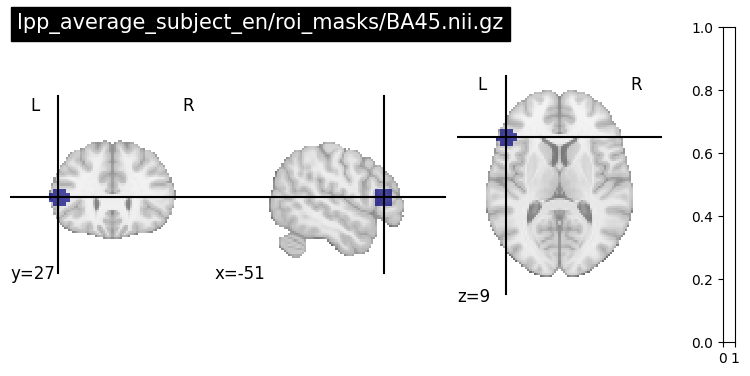

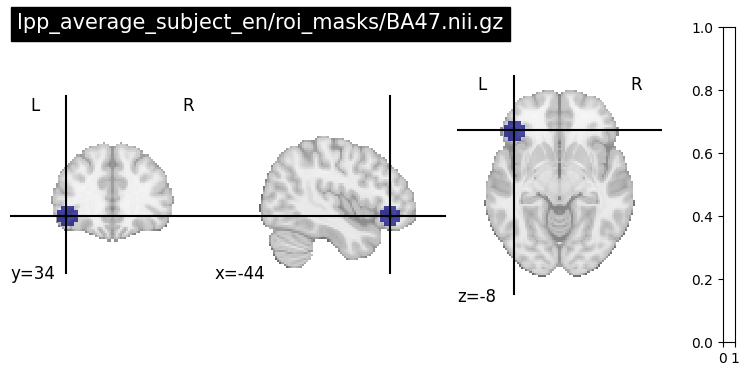

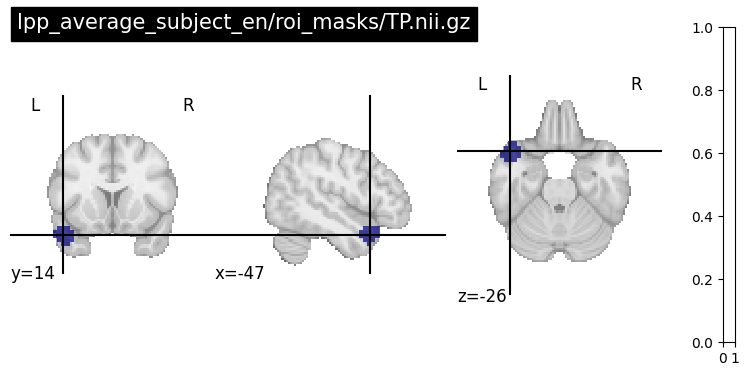

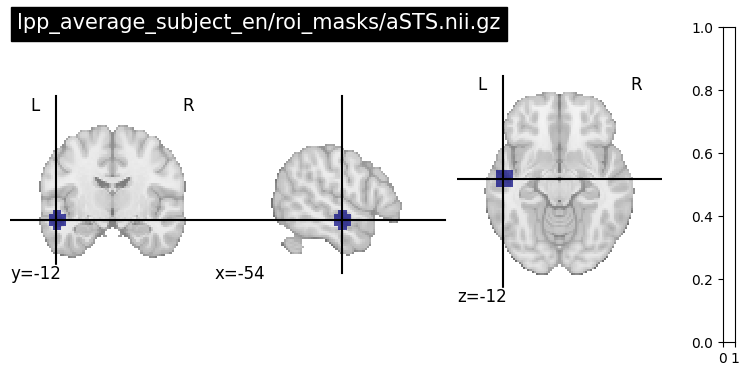

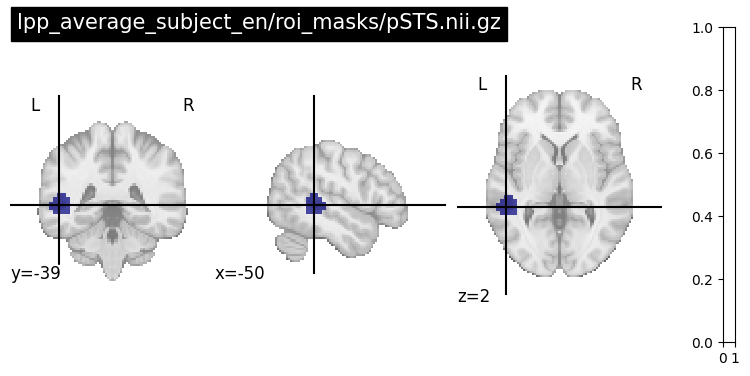

In [7]:
rois_dir = root_dir / "roi_masks"
rois_files = sorted(list(rois_dir.glob("*.nii.gz")))
print(rois_files)

from nilearn.plotting import plot_roi
for r in rois_files:
  plot_roi(r, title=str(r))

# Extract time-series from run 1 in roi 1


lpp_average_subject_en/roi_masks/AG_TPJ.nii.gz
(282, 56)


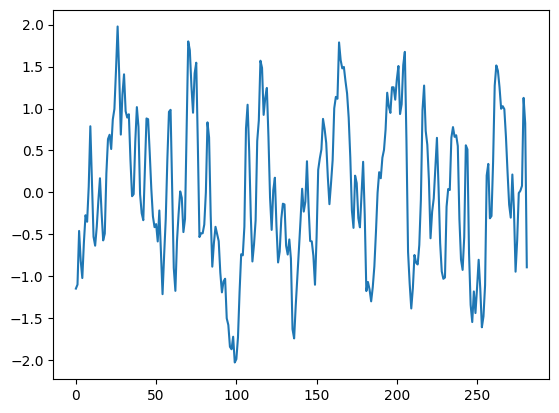

In [8]:
from nilearn.maskers import NiftiMasker

print(rois_files[0])

tpj_mask = NiftiMasker(rois_files[0], standardize=True, detrend=True)
tpj_data  = tpj_mask.fit_transform(bold_files[0])

print(tpj_data.shape) # we have one time-series per voxel

tpj_signal = tpj_data.mean(axis=1)
plt.plot(tpj_signal)



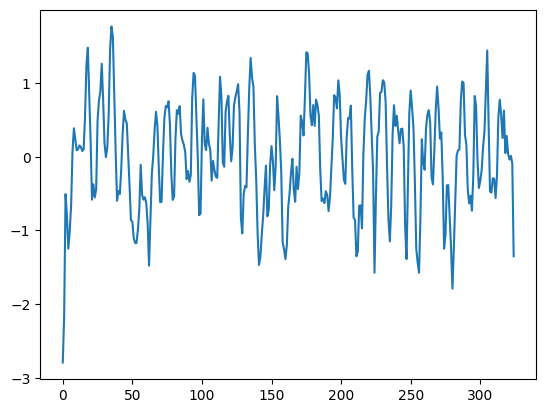

In [9]:

psts_mask = NiftiMasker(rois_files[6], standardize=True, detrend=True)
psts_data  = psts_mask.fit_transform(bold_files[6])
psts_signal = psts_data.mean(axis=1)
plt.plot(psts_signal)

# get acoustic intensity from annotations

The acoustic energy is the root mean square of the signal in the wave files, sampled every 10ms

In [10]:
import pandas as pd
lowlevel = pd.read_csv(root_dir / "annotation" / "lppEN_prosody.csv")

lowlevel.head(20)

Unnamed: 0  time      f0  intensity  section
0            0  0.01    0.00       0.00        1
1            1  0.02    0.00       0.00        1
2            2  0.03    0.00       0.00        1
3            3  0.04    0.00       0.00        1
4            4  0.05    0.00       0.00        1
5            5  0.06    0.00       0.00        1
6            6  0.07    0.00       0.00        1
7            7  0.08    0.00       0.00        1
8            8  0.09    0.00       0.00        1
9            9  0.10    0.00       0.00        1
10          10  0.11    0.00       0.00        1
11          11  0.12    0.00       0.00        1
12          12  0.13  110.29       0.01        1
13          13  0.14  244.63       0.07        1
14          14  0.15  239.41       0.13        1
15          15  0.16  233.30       0.15        1
16          16  0.17  233.35       0.16        1
17          17  0.18  235.04       0.15        1
18          18  0.19  237.24       0.15        1
19          19  0.20  239.77       0.14        1

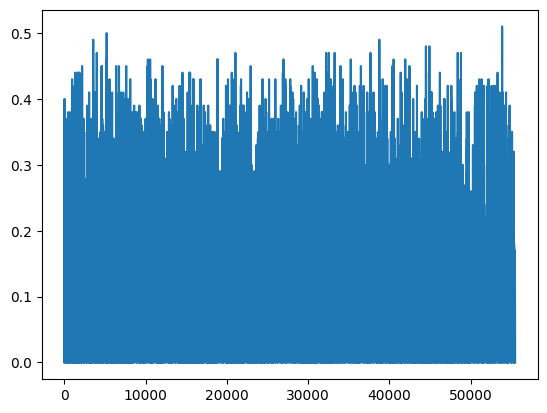

In [11]:
# acoustic energy

rms = lowlevel.intensity[lowlevel.section==1]

plt.plot(rms)

We cannot directly compute the correlation between energy and fmri signal.

1. they are not sampled at the same freq
2.  we have to take into acount the fmri impulse response, and convolute acoustic energy by this response.



In [ ]:
from nilearn.glm.first_level import spm_hrf

?spm_hrf

plt.plot(spm_hrf(1.))


To avoid having to perform the convolution manually, nilearn provides a fonction `compute_regressor`

[[ 1.  20.  30. ]
 [ 1.   1.   1. ]
 [ 0.5  2.   1. ]]


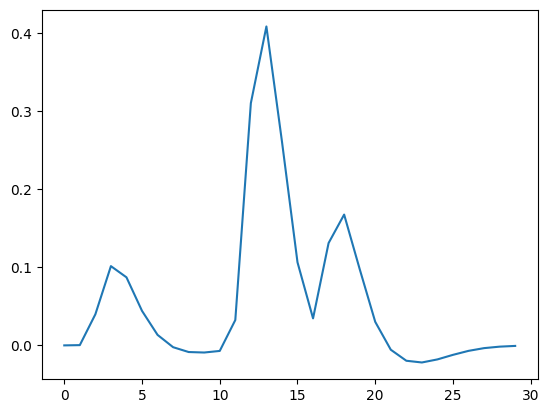

In [12]:
from nilearn.glm.first_level import compute_regressor

# we define 3 events occring at times 1s, 20s and 40s
onsets = np.array([1, 20, 30])
durations = np.array([1, 1, 1])
amplitudes = np.array([0.5, 2, 1])

condition = np.vstack([onsets, durations, amplitudes])
print(condition)

TR = 2.   # fmri repetition time
n_volumes = 30
frame_times = TR * np.arange(n_volumes)


predictor = compute_regressor(condition, hrf_model='spm', frame_times=frame_times)
plt.plot(predictor[0])



In [13]:
from nilearn.image import load_img

# get the number of scans from run1
run1 = load_img(bold_files[0])
print(run1.shape)

n_volumes = run1.shape[3]
# create the temporal grid
TR = 2.   # fmri repetition time
frame_times = TR * np.arange(n_volumes)
print(frame_times)





(37, 46, 38, 282)
[  0.   2.   4.   6.   8.  10.  12.  14.  16.  18.  20.  22.  24.  26.
  28.  30.  32.  34.  36.  38.  40.  42.  44.  46.  48.  50.  52.  54.
  56.  58.  60.  62.  64.  66.  68.  70.  72.  74.  76.  78.  80.  82.
  84.  86.  88.  90.  92.  94.  96.  98. 100. 102. 104. 106. 108. 110.
 112. 114. 116. 118. 120. 122. 124. 126. 128. 130. 132. 134. 136. 138.
 140. 142. 144. 146. 148. 150. 152. 154. 156. 158. 160. 162. 164. 166.
 168. 170. 172. 174. 176. 178. 180. 182. 184. 186. 188. 190. 192. 194.
 196. 198. 200. 202. 204. 206. 208. 210. 212. 214. 216. 218. 220. 222.
 224. 226. 228. 230. 232. 234. 236. 238. 240. 242. 244. 246. 248. 250.
 252. 254. 256. 258. 260. 262. 264. 266. 268. 270. 272. 274. 276. 278.
 280. 282. 284. 286. 288. 290. 292. 294. 296. 298. 300. 302. 304. 306.
 308. 310. 312. 314. 316. 318. 320. 322. 324. 326. 328. 330. 332. 334.
 336. 338. 340. 342. 344. 346. 348. 350. 352. 354. 356. 358. 360. 362.
 364. 366. 368. 370. 372. 374. 376. 378. 380. 382. 384. 386

In [14]:
# prepare information to compute intensity predictor
onsets = lowlevel.time
durations = np.zeros(len(lowlevel))
amplitudes = lowlevel.intensity
condition = np.vstack([onsets, durations, amplitudes])
print(condition)

[[1.0000e-02 2.0000e-02 3.0000e-02 ... 7.2708e+02 7.2709e+02 7.2710e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]]


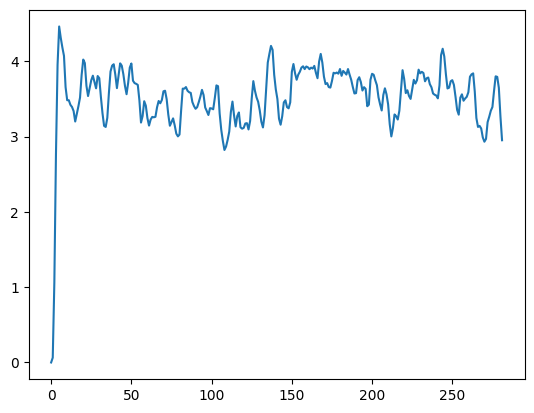

In [15]:
rms_predictor = compute_regressor(condition, hrf_model='spm', frame_times=frame_times)
plt.plot(rms_predictor[0])

In [16]:
x = rms_predictor[0].ravel()
y = tpj_signal
print(np.corrcoef(x, y))



[[1.         0.13137105]
 [0.13137105 1.        ]]


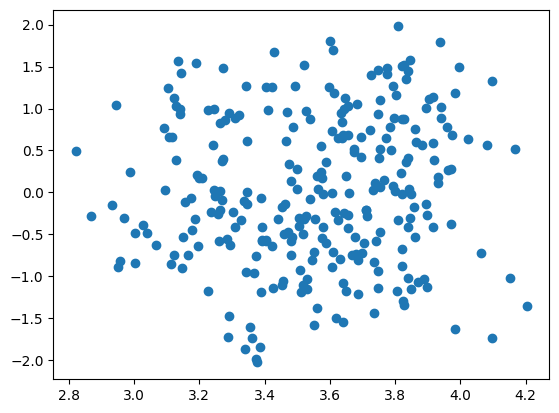

In [17]:
plt.scatter(x[10:], y[10:])

# extract data from the (left) auditoy cortex

There is no ROI for the auditory cortex, but we can create one using the MNI atlas coordinates (-50, -20, 8).




In [18]:
from nilearn.maskers import NiftiSpheresMasker

auditory_cortex_masker = NiftiSpheresMasker(seeds=[(-50, -20, 8)],  standardize=True, detrend=True)
aud = auditory_cortex_masker.fit_transform(run1).T

np.corrcoef(x, aud)

array([[1.        , 0.41965886],
       [0.41965886, 1.        ]])

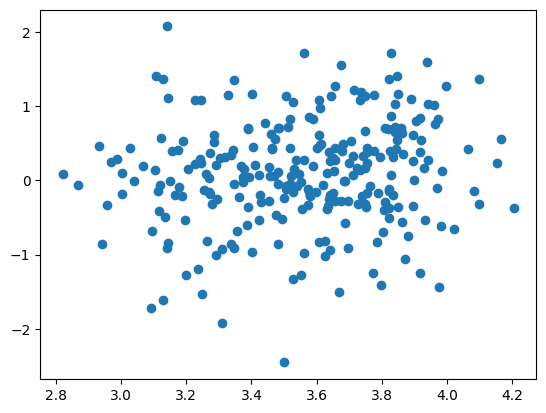

In [19]:
plt.scatter(x[10:-10], aud.T[10:-10])

# Exercice:   

We just computed the correlation for run1, compute the correlations for the 8 other runs.

In [ ]:
# TODO

# Full brain

Rather than using ROIs, we can get the signal in each voxel, using a mask of the full brain



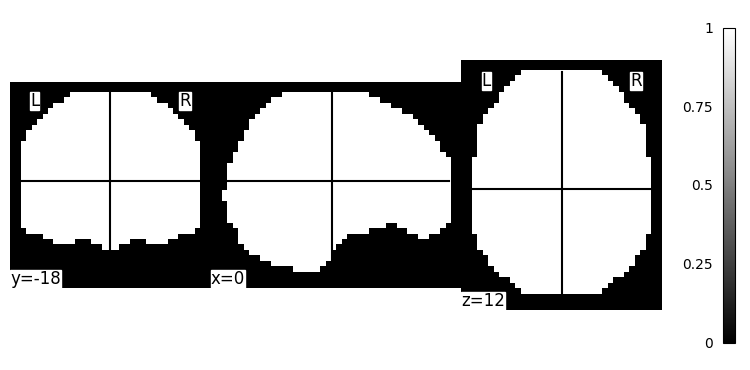

In [20]:
from nilearn.plotting import plot_img
plot_img(root_dir / "mask_lpp_en.nii.gz")
mask = NiftiMasker(root_dir / "mask_lpp_en.nii.gz", detrend=True, standardize=True)


In [21]:
# extracting data from the first run

fmri_data = mask.fit_transform(bold_files[0])
print(fmri_data.shape)

(282, 25870)


(282, 1)
(25870,)


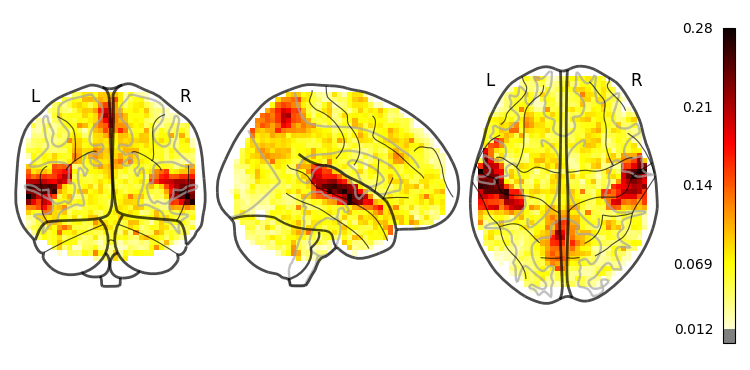

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from nilearn.plotting import plot_glass_brain

# we use rms (x) as a single predictor
X = np.array([x]).T
print(X.shape)

model = LinearRegression().fit(X, fmri_data)

y_predicted = model.predict(X)

r2 = r2_score(fmri_data, y_predicted,  multioutput='raw_values')
print(r2.shape)

r2map = mask.inverse_transform(r2)
plot_glass_brain(r2map)

# Exercice:

Perform a similar analysis using the `logfreq predictor` from `annotation/lppEN_word_information.csv`

In [23]:
! head lpp_average_subject_en/annotation/lppEN_word_information.csv

,word,lemma,onset,offset,logfreq,pos,section,top_down,bottom_up,left_corner
0,once,once,0.113,0.728,5.82440591697994,ADV,1,3,1,2
1,when,when,0.728,0.919,7.562213604926971,ADV,1,2,2,2
2,i,i,0.919,1.025,8.500758884952813,PRON,1,3,2,3
3,was,was,1.025,1.158,8.84891128785763,AUX,1,2,1,2
4,six,six,1.158,1.464,5.20893955539682,NUM,1,3,1,2
5,years,years,1.464,1.671,6.569635686214575,NOUN,1,1,2,2
6,old,old,1.671,1.973,6.186188047557115,ADJ,1,1,5,2
7,i,i,2.342,2.48,8.500758884952813,PRON,1,2,2,2
8,saw,saw,2.48,2.687,5.319491601779443,VERB,1,2,1,2


In [24]:
word_info = pd.read_csv(root_dir / "annotation" / "lppEN_word_information.csv", keep_default_na=False)

In [ ]:
# TODO

# cross-validation

Until now, we computed r-squares from the data on which the model was fit.

To avoid overfitting, a better idea is to compute the correlation with data that were not used to fit the model.

For exaple, fit on data from runs 1 to 8 and predict for run 9.



The library [scikit-learn](https://scikit-learn.org) provides functions to help with implementing cross validation:

In [25]:
from sklearn.model_selection import LeaveOneGroupOut

logo = LeaveOneGroupOut()
for train, test in logo.split(bold_files, groups=range(1, 10)):
     print(train, test)

[1 2 3 4 5 6 7 8] [0]
[0 2 3 4 5 6 7 8] [1]
[0 1 3 4 5 6 7 8] [2]
[0 1 2 4 5 6 7 8] [3]
[0 1 2 3 5 6 7 8] [4]
[0 1 2 3 4 6 7 8] [5]
[0 1 2 3 4 5 7 8] [6]
[0 1 2 3 4 5 6 8] [7]
[0 1 2 3 4 5 6 7] [8]


See https://github.com/chrplr/lpp-scripts3/blob/master/r2maps_glm_crossval.py

# Several Regressors

When the number of predictorn is small (e.g. less number of scans / 20), you can use a standard multiple Linear Regression., using scikit-learn `LinearRegression()`


If there are "too" many predictors, you can:
* either perform dimension reduction (e.g. PCA) on the features,
* or use  scikitlearn `Ridge()`. For thos familiar with Rifge, you need to set a parameter (alpha). This can be done through crossvalidation, in each voxel or at the whole brain.



In [26]:
lpp_words = word_info[["word","offset","section"]]

lpp_words

word   offset  section
0      once    0.728        1
1      when    0.919        1
2         i    1.025        1
3       was    1.158        1
4       six    1.464        1
...     ...      ...      ...
15371  tell  726.295        9
15372    me  726.435        9
15373    he  726.525        9
15374     s  726.615        9
15375  back  727.034        9

[15376 rows x 3 columns]

# Exercice:

Compute r2 map from the model using spacy embeddings

In [27]:
! uv pip install spacy

Using Python 3.12.11 environment at: /usr
Audited 1 package in 121ms


In [28]:
import spacy
language_model = spacy.load("en_core_web_sm")

m = []
for w in lpp_words.word:
  doc = language_model(w)
  if doc.has_vector:
        m.append(doc[0].vector)
  else:
     m.append(np.zeros((96,)))

spacy_emb = np.array(m)



In [29]:
winfo = pd.concat([word_info, pd.DataFrame(spacy_emb)], axis=1)
winfo.head()

Unnamed: 0  word lemma  onset  offset   logfreq   pos  section  top_down  \
0           0  once  once  0.113   0.728  5.824406   ADV        1         3   
1           1  when  when  0.728   0.919  7.562214   ADV        1         2   
2           2     i     i  0.919   1.025  8.500759  PRON        1         3   
3           3   was   was  1.025   1.158  8.848911   AUX        1         2   
4           4   six   six  1.158   1.464  5.208940   NUM        1         3   

   bottom_up  ...        86        87        88        89        90        91  \
0          1  ...  0.569818  0.854297 -0.407572  0.510961  0.460939 -0.191909   
1          2  ... -0.111130 -0.644808  1.804016  0.623487  0.138981 -0.250637   
2          2  ... -0.378853  0.399974  1.755298 -0.033879  1.165812 -0.040527   
3          1  ...  0.634376  0.215818 -1.088062 -0.564889  0.235468 -0.154427   
4          1  ... -0.553110 -0.077004 -0.407573  1.397509  0.380050  0.280215   

         92        93        94        95  
0 -0.626718  0.239501 -0.942687 -0.782371  
1 -1.660219  0.165365 -0.506217 -0.197727  
2  0.324967 -0.236076 -0.915406  1.538739  
3 -1.228522 -0.769285  0.576875  1.226002  
4  0.450034  0.600502 -0.178226  0.863359  

[5 rows x 107 columns]

In [30]:
# keep only run1 info

run1 = winfo[winfo.section==1]
emb1 = spacy_emb[:len(run1),:]
print(emb1.shape)


(1517, 96)


Now, for each column in spacy , we need to generate a regressor with `compute_regressor`

In [31]:
onsets = run1.onset
durations = np.zeros(len(onsets))

preds = []
for i in range(emb1.shape[1]):
  predictor = compute_regressor(np.vstack([onsets, durations, emb1[:,i]]),
                                hrf_model='spm',
                                frame_times=frame_times)
  preds.append(predictor[0])

spacy_regressors = np.array(preds)
spacy_regressors.shape

regs = spacy_regressors[:,:,0].T
regs.shape



(282, 96)

Let's perform the regression on tpj_signal in run1




In [32]:
print(tpj_signal.shape)

(282,)


In [33]:
tpj_signal_reshaped = tpj_signal.reshape(-1,1)

In [34]:
tpj_signal_reshaped.shape

(282, 1)

[0.43782638]


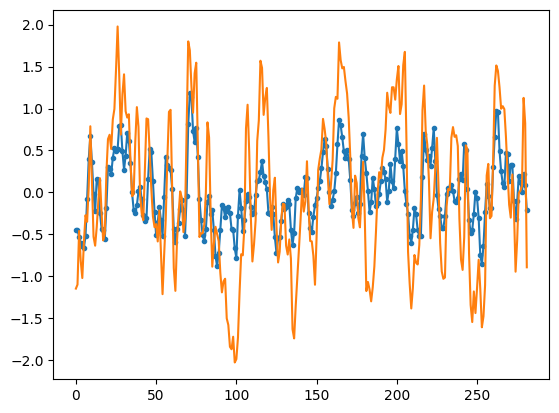

In [35]:
from sklearn.metrics import r2_score

from sklearn.linear_model import Ridge

model = Ridge(alpha=0.1).fit(regs, tpj_signal_reshaped)

y_predicted = model.predict(regs)
r2 = r2_score(tpj_signal_reshaped, y_predicted,  multioutput='raw_values')
print(r2)
plt.plot(y_predicted,'.-')
plt.plot(tpj_signal_reshaped)


In [37]:
model = Ridge(alpha=0.1).fit(regs, fmri_data)

y_predicted = model.predict(regs)
r2 = r2_score(fmri_data, y_predicted,  multioutput='raw_values')
print(r2)

[0.3207512  0.37229074 0.39578581 ... 0.28495835 0.28296334 0.27636712]


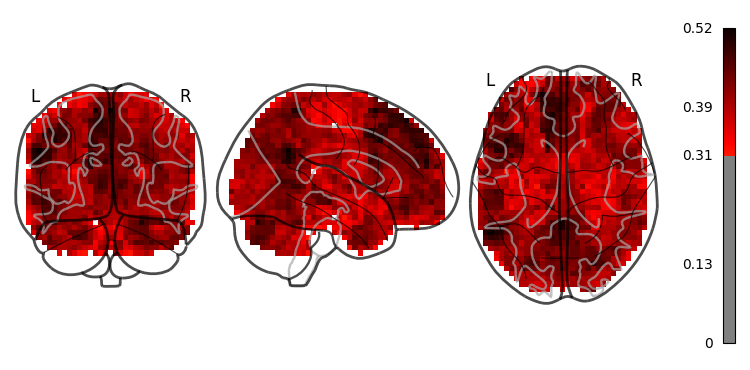

In [38]:
r2map = mask.inverse_transform(r2)
plot_glass_brain(r2map)

# Real-life examples:

* https://github.com/l-bg/llms_brain_lateralization


* https://github.com/l-bg/simple_composition_fmri/blob/master/main.ipynb

# Nilearn tutorials

https://nilearn.github.io/dev/auto_examples/index.html

